In [78]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]
 
MAX_THRESHOLD_CONST = 3.98 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500

In [2]:
src = f"/home/andres/repos/rat-mapping-paper/reports/J_SHAP/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ :400,...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (400, 8, 16, 4, 6)
b (400, 8, 16, 4, 6)
L (400, 8, 16, 4, 6)
ℓ (400, 8, 16, 4, 6)
H (400, 8, 16, 4, 6)


In [4]:
subjects = sorted(df['participant'].unique())
# subjects = encoder_dict['participant'].inverse_transform(subjects)
positions = sorted(df['compound_position'].unique())
# positions = encoder_dict['compound_position'].inverse_transform(positions)
charges = sorted(df['compound_charge_params'].unique())
# charges = encoder_dict['compound_charge_params'].inverse_transform(charges)
muscles = model.response

In [62]:
charges = charges[:3]

In [64]:
charges

[0, 1, 2]

In [65]:
compound_position = encoder_dict[model.features[1]].inverse_transform(sorted(df['compound_position'].unique()))
mono = [c for c in compound_position if c.split("-")[0] == "" or c.split("-")[1] == ""]
mono = np.array(mono)
mono = mono[:3]
mono_inds = encoder_dict[model.features[1]].transform(mono)

In [66]:
compound_position

array(['-C6L', '-C7L', '-C8L', 'C6L-', 'C6L-C6M', 'C6L-C7L', 'C6M-C6L',
       'C7L-', 'C7L-C6L', 'C7L-C7M', 'C7L-C8L', 'C7M-C7L', 'C8L-',
       'C8L-C7L', 'C8L-C8M', 'C8M-C8L'], dtype=object)

In [67]:
mono_inds

array([0, 1, 2])

# Get Constant

In [68]:
stim_max = []

for s in subjects:
    for p in mono_inds:
        for c in charges:
            for m in muscles: 
                temp = df[(df['participant'] == s) 
                        & (df['compound_position'] == p) 
                        & (df['compound_charge_params'] == c)
                        ]
                temp = temp.loc[:,[m, 'pulse_amplitude']]
                temp = temp.pulse_amplitude.max()
                stim_max.append(temp)
stim_max = ma.array(stim_max)
stim_max = stim_max.reshape(len(subjects), len(mono_inds), len(charges), len(muscles))

In [69]:
stim_max.shape

(8, 3, 3, 6)

In [70]:
a = posterior_samples[site.a]

In [71]:
a.shape

(4000, 8, 16, 4, 6)

In [74]:
a = a[:,:,mono_inds,:3,:]

In [75]:
a.shape

(4000, 8, 3, 3, 6)

In [76]:
(stim_max/ma.mean(a, axis=0)).shape

(8, 3, 3, 6)

In [77]:
ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis = 0)

3.9882024369635976

# Selectivity Calc

In [79]:
norm_y = []
norm_x = []

for subject_ind, subject in enumerate(subjects):
    for c in charges:
        # Fix the subject index and size index
        curr_params = [
            params[:, subject_ind, mono_inds, c,:, None] for params in params
        ]

        # Take nanmean across posterior samples
        temp = np.nanmean(curr_params[0], axis=0)
        
        # Take nanmedian across compound positions and muscles
        median_threshold = np.nanmedian(temp)

        x_temp = np.linspace(0.,  median_threshold * MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)
        x_temp = x_temp[ None, None, None,:]

        temp_thresh = F.rectified_logistic(
            x_temp, #x_temp
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)
norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(charges), *norm_x.shape[1:])
norm_y = np.array(norm_y)
norm_y = ma.masked_invalid(norm_y)
norm_y = norm_y.reshape(len(subjects), len(charges), *norm_y.shape[1:])

/tmp/ipykernel_4014251/599926144.py:12: RuntimeWarning: Mean of empty slice
  temp = np.nanmean(curr_params[0], axis=0)


In [81]:
norm_y.shape

(8, 3, 400, 3, 6, 500)

In [82]:
y = norm_y

In [83]:
y_max = ma.max(y, axis=(1,4, -1), keepdims=True)
y = ma.where(y_max, y / y_max, 0.)


In [84]:
p = ma.sum(y, axis=-2, keepdims=True)

In [85]:
p = ma.where(p, y / p, 1 / y.shape[-2])

In [86]:
plogp = ma.where(p, p * ma.log(p), 0.)

In [87]:
entropy = 1 + (plogp.sum(axis=-2) / ma.log(y.shape[-2]))

In [88]:
auc = np.trapz(y=entropy[...], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS), axis=-1)
auc.shape

(8, 3, 400, 3)

In [89]:
auc = auc.mean(axis=(2))
auc.shape

(8, 3, 3)

In [97]:
src = f"/home/andres/repos/rat-mapping-paper/notebooks/J_SHAP/shape_selectivity_means.pkl"

with open(src, "wb") as f:
    pickle.dump(auc, f)

In [91]:
mat = auc[:, :, None,:] - auc[:,None, :, :]

In [92]:
mat.shape

(8, 3, 3, 3)

In [93]:
mat = mat.mean(axis=3)

In [94]:
encoder_dict

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'participant': LabelEncoder(),
             'compound_position': LabelEncoder(),
             'compound_charge_params': LabelEncoder()})

<Axes: >

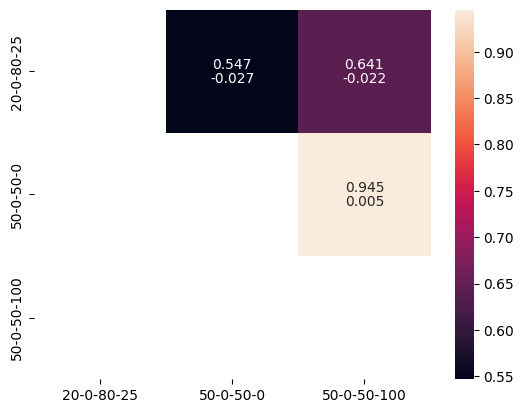

In [95]:
labels = encoder_dict['compound_charge_params'].inverse_transform(charges)
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(mat[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))

mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [96]:
len(labels)

3